# Project: Loan Status Prediction

## Table of Contents
<ul>
<li><a href="#intro">Project Overview</a></li>
<li><a href="#library">Import Library</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#analysis">Data Visualization</a></li>
<li><a href="#model">Building Model</a></li>
<li><a href="#eva">Model Evaluation and Predictions</a></li>
</ul>

<a id='intro'></a>
## Project Overview
This project utilizes ARCH models to predict stock volatility using historical data from Yahoo Finance. By analyzing past stock performance within a specified timeframe, the machine learning model aims to provide accurate forecasts of future volatility. Investors and traders can benefit from these predictions, enabling them to make informed decisions and manage risks effectively in the stock market.

<a id='library'></a>
## Import Library
 

In [1]:
import os
import joblib

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import math


from datetime import date, timedelta

import yfinance as yf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

from arch import arch_model

from sklearn.metrics import mean_absolute_error

import time


<a id='wrangling'></a>
## Data Wrangling


In [2]:
def get_data(ticker, n=100):
    """
    Retrieves historical stock data for a specified ticker symbol from Yahoo Finance within a given time window.
    
    Parameters:
    - ticker (str): The stock ticker symbol of the company for which historical data is requested.
    - n (int, optional): Number of days of historical data to retrieve, counting backwards from the current date. Default is 100 days.
    
    Returns:
    - data (pandas.DataFrame): A DataFrame containing historical stock data including columns such as 'Open', 'High', 'Low', 'Close', 'Volume', and 'Adj Close'.
    """
    # Specify start dates and end dates
    end_date = date.today()
    start_date = end_date - timedelta(days=n)
    
    data = yf.download(ticker, start=start_date, end=end_date)

    return data

In [3]:
data = get_data('TSLA')

[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-17,286.630005,292.230011,283.570007,290.380005,290.380005,131569600
2023-07-18,290.149994,295.260010,286.010010,293.339996,293.339996,112434700
2023-07-19,296.040009,299.290009,289.519989,291.260010,291.260010,142355400
2023-07-20,279.559998,280.929993,261.200012,262.899994,262.899994,175158300
2023-07-21,268.000000,268.000000,255.800003,260.019989,260.019989,161050100


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 2023-07-17 to 2023-10-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       71 non-null     float64
 1   High       71 non-null     float64
 2   Low        71 non-null     float64
 3   Close      71 non-null     float64
 4   Adj Close  71 non-null     float64
 5   Volume     71 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 3.9 KB


In [6]:
data['return']  = data['Adj Close'].pct_change() * 100

type(data['return'].dropna())

pandas.core.series.Series

In [7]:
def get_return(ticker,n=100):
    """
    Retrieves the daily percentage returns of a stock specified by its ticker symbol from Yahoo Finance.
    
    Parameters:
    - ticker (str): The stock ticker symbol (e.g., 'TSLA' for Tesla) for which returns are calculated.
    - n (int, optional): Number of days of historical data to consider for calculating returns, counting backwards from the current date. Default is 100 days.
    
    Returns:
    - returns (pandas.Series): A Series containing the daily percentage returns of the specified stock.
    """
    data = get_data(ticker,n)
        
    data['return']  = data['Adj Close'].pct_change() * 100

    return data['return'].dropna()

In [8]:
df = get_return(ticker='TSLA',n=1000)

[*********************100%%**********************]  1 of 1 completed


In [9]:
df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 689 entries, 2021-01-29 to 2023-10-24
Series name: return
Non-Null Count  Dtype  
--------------  -----  
689 non-null    float64
dtypes: float64(1)
memory usage: 10.8 KB


In [10]:
df.head()

Date
2021-01-29   -5.015373
2021-02-01    5.832167
2021-02-02    3.927073
2021-02-03   -2.073807
2021-02-04   -0.549912
Name: return, dtype: float64

<a id='analysis'></a>
## Data Visualization


In [11]:
def trend_plot(dataframe=df):
    """
    Plots a trend chart for the given DataFrame representing stock returns over time.
    
    Parameters:
    - dataframe (pandas.DataFrame, optional): DataFrame containing stock return data. Default is df.
    
    Returns:
    - None
    """
    fig, ax = plt.subplots(figsize = (18,8))
    ax.plot(dataframe)
    plt.yticks(fontweight = 'bold')
    plt.xticks( rotation = 'vertical', fontweight = 'bold')
    plt.ylabel('Return', fontsize = 12, fontweight = 'bold')
    plt.xlabel('Date', fontsize = 12, fontweight = 'bold')
    title = ' Return trend With Time'
    plt.title(title, fontsize = 25, fontweight = 'bold', loc = 'center')
    plt.show();

In [12]:
def acf_plot(lag,dataframe=df):
    """
    Plots the Autocorrelation Function (ACF) for the given DataFrame representing stock returns.
    
    Parameters:
    - lag (int): Number of lags to consider in the ACF plot.
    - dataframe (pandas.DataFrame, optional): DataFrame containing stock return data. Default is df.
    
    Returns:
    - None
    """
    fig, ax = plt.subplots(figsize = (18, 8))
    plot_acf(dataframe, ax=ax, lags=lag);
    plt.xlabel("Lag [Month]", fontsize=12, fontweight='bold')
    plt.ylabel("Correlation Coefficient", fontsize=12, fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.title(f"ACF Plot for Return", fontsize=25, fontweight='bold')

    plt.show();

In [13]:
def pacf_plot(lag,dataframe=df):
    """
    Plots the Partial Autocorrelation Function (PACF) for the given DataFrame representing stock returns.
    
    Parameters:
    - lag (int): Number of lags to consider in the PACF plot.
    - dataframe (pandas.DataFrame, optional): DataFrame containing stock return data. Default is df.
    
    Returns:
    - None
    """
    fig, ax = plt.subplots(figsize = (18, 8))
    plot_pacf(dataframe, ax=ax, lags=lag);
    plt.xlabel("Lag [Month]", fontsize=12, fontweight='bold')
    plt.ylabel("Correlation Coefficient", fontsize=12, fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.title(f"PACF Plot for Return", fontsize=25, fontweight='bold')

    plt.show();

In [14]:
def rolling_mean_plot(n,dataframe=df):
    """
    Plots the stock returns and their rolling mean over a specified window size.
    
    Parameters:
    - n (int): Number of days for the rolling mean calculation.
    - dataframe (pandas.DataFrame, optional): DataFrame containing stock return data. Default is df.
    
    Returns:
    - None
    """
    rolling = dataframe.rolling(n).std()
    fig,ax = plt.subplots(figsize = (18,8)) 
    ax.plot(dataframe)
    ax.plot(rolling,color ='red',label='Rolling Mean of return')
    plt.yticks(fontweight = 'bold')
    plt.xticks(rotation = 'vertical', fontweight = 'bold')
    plt.ylabel('Return', fontsize = 12, fontweight = 'bold')
    plt.xlabel('DateTime', fontsize = 12, fontweight = 'bold')
    plt.title(f'Returns rolling mean  for {n} days', fontsize = 25, fontweight = 'bold')

    plt.legend(loc = "best")
    plt.show();

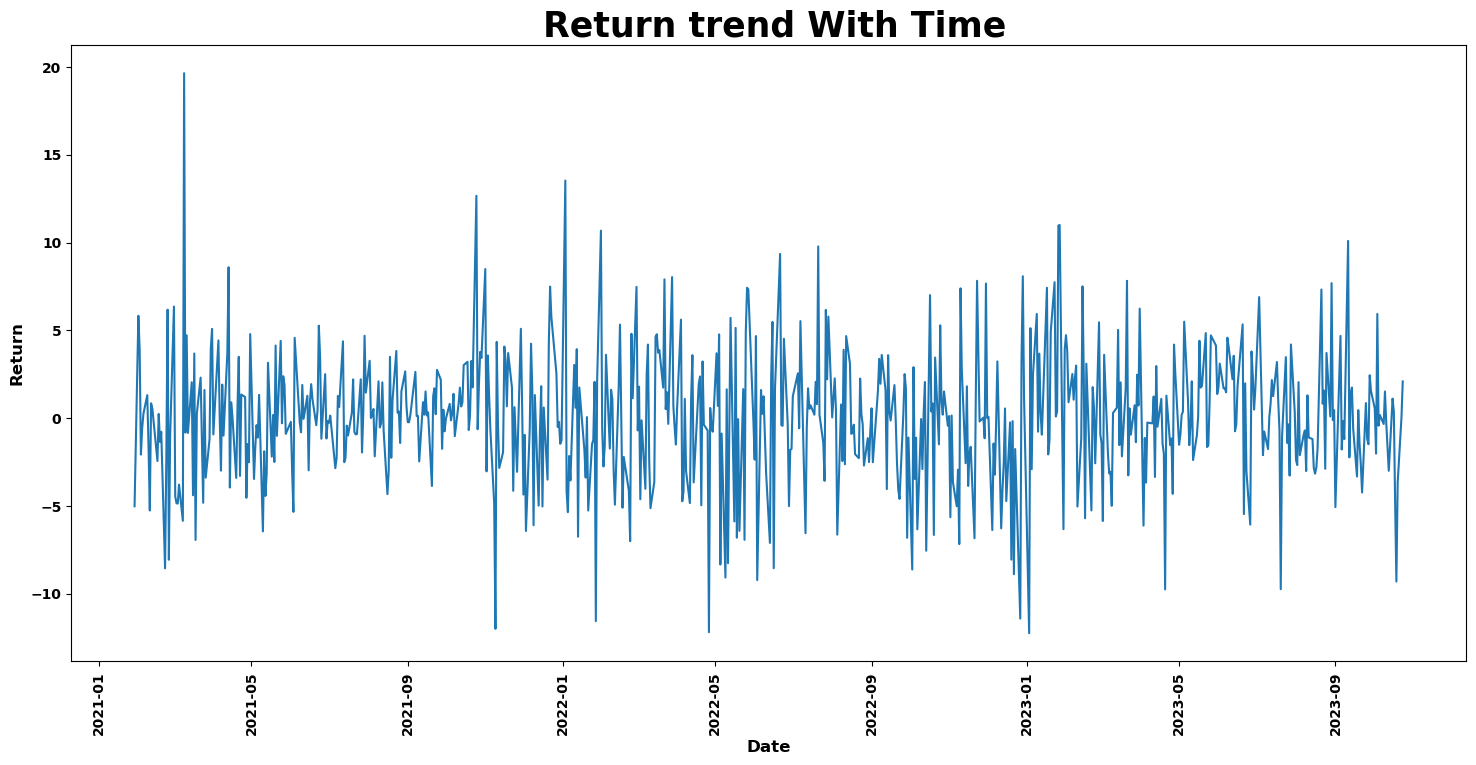

In [15]:
trend_plot()

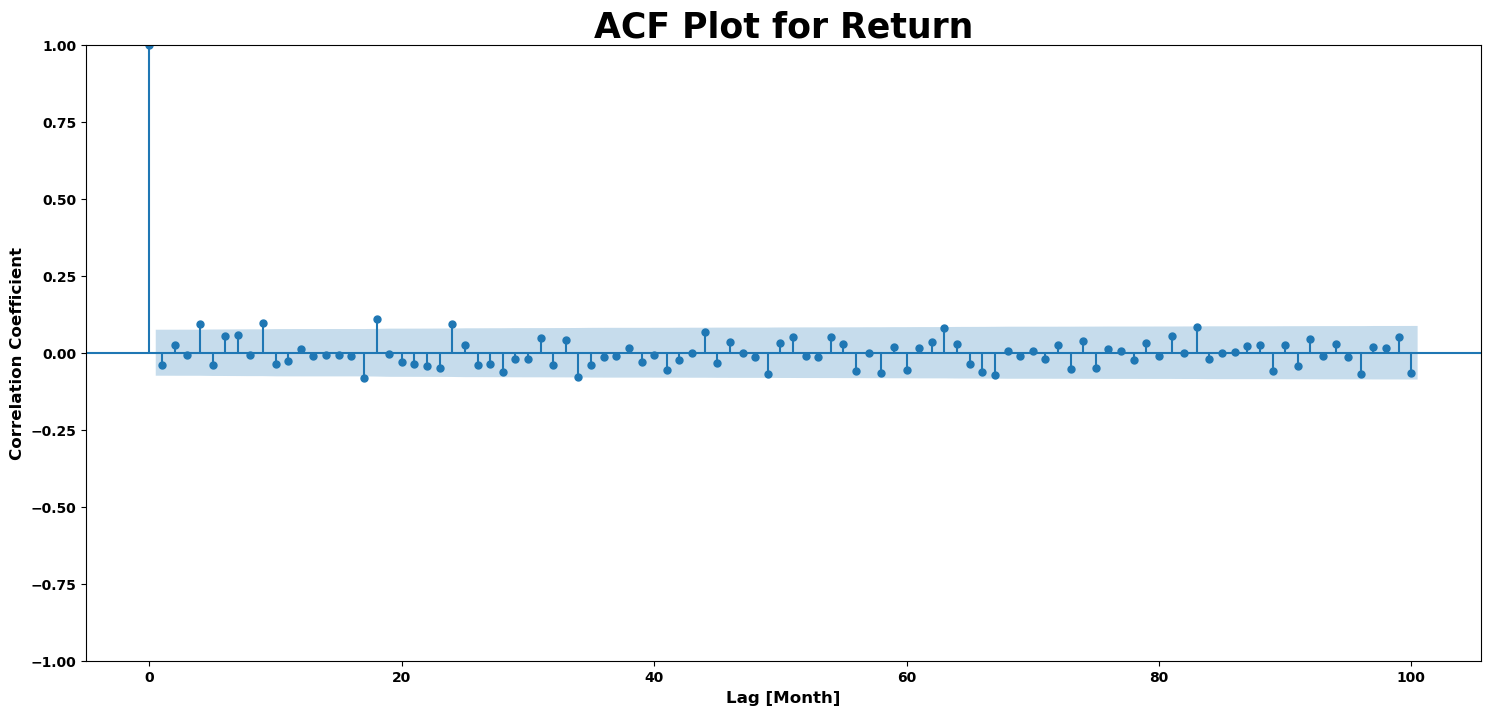

In [16]:
acf_plot(lag=100)

C:\Users\YUSUF\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


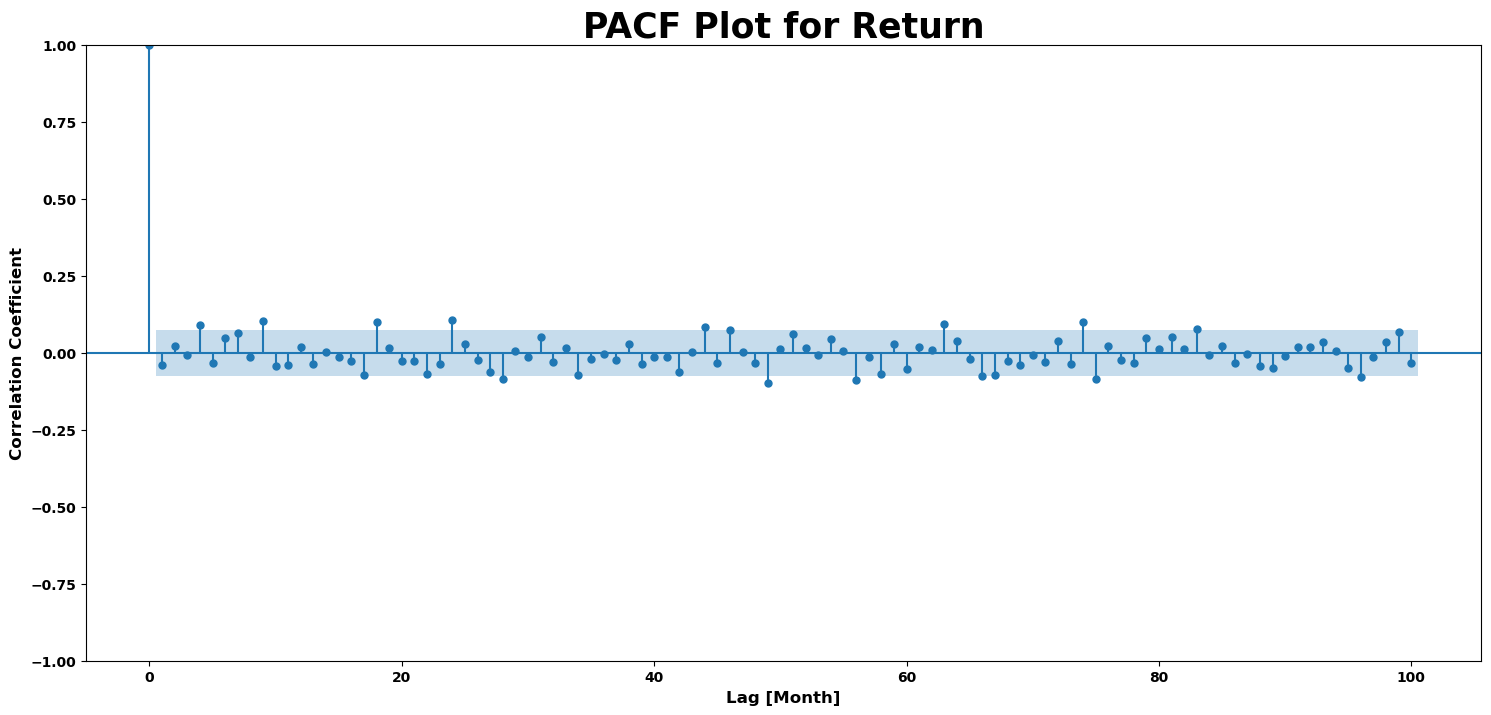

In [17]:
pacf_plot(lag=100)

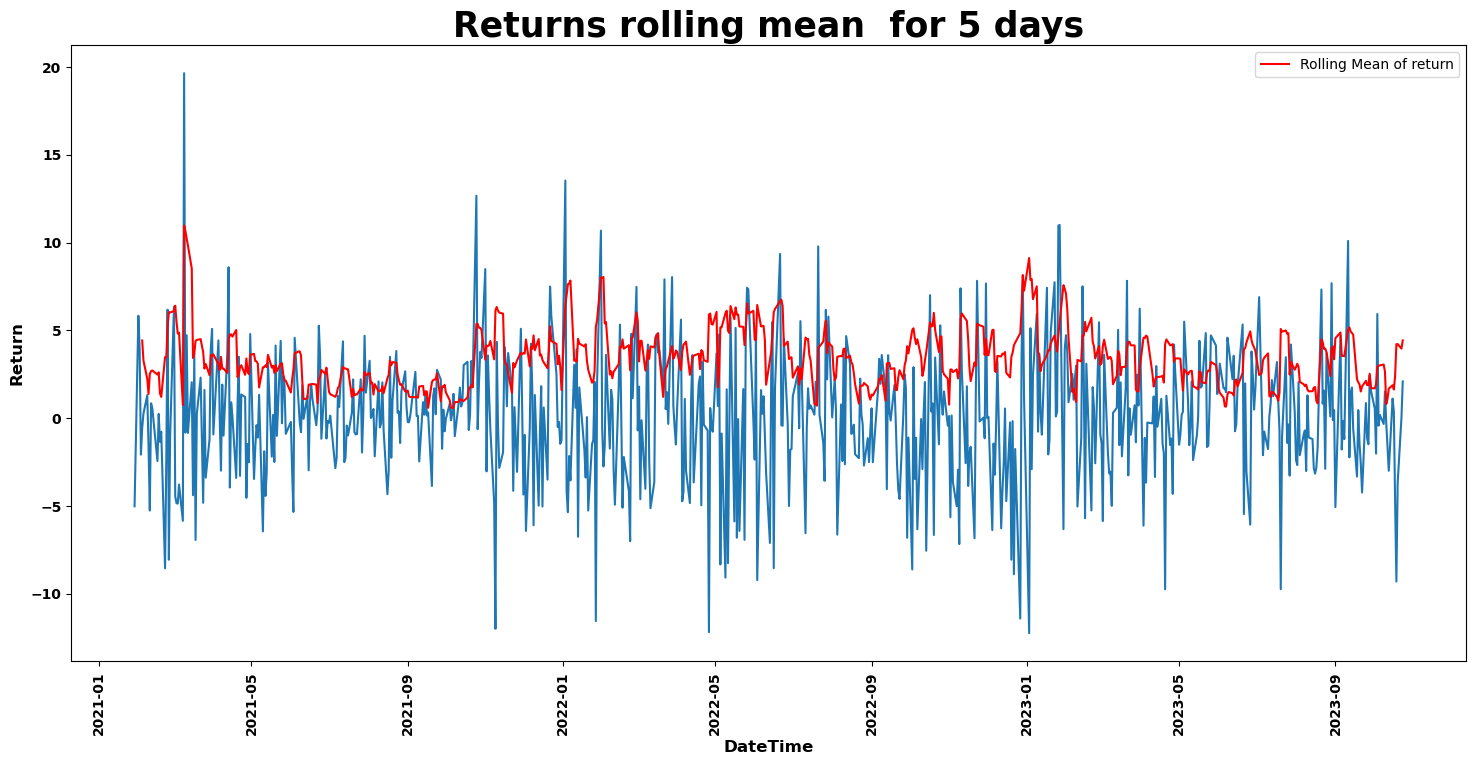

In [18]:
rolling_mean_plot(n=5)

<Axes: ylabel='Density'>

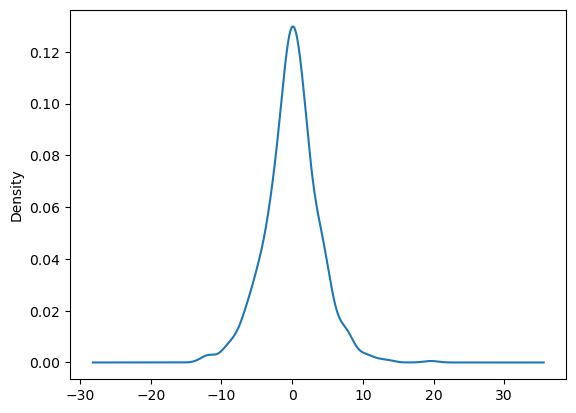

In [19]:
df.plot(kind='kde')

In [20]:
daily_volatility =  df.std()

In [21]:
annual_volatility = daily_volatility * np.sqrt(252)

In [22]:
annual_volatility

59.78155651001143

<a id='model'></a>
## Building the Model

In [23]:
cut_off = math.ceil(df.shape[0] * 0.8)
df_train,df_test = df[:cut_off],df[cut_off:]

In [24]:
df_train.head()

Date
2021-01-29   -5.015373
2021-02-01    5.832167
2021-02-02    3.927073
2021-02-03   -2.073807
2021-02-04   -0.549912
Name: return, dtype: float64

In [25]:
df_test.tail()

Date
2023-10-18   -4.775363
2023-10-19   -9.300310
2023-10-20   -3.689062
2023-10-23    0.042453
2023-10-24    2.093551
Name: return, dtype: float64

In [26]:
# Build and train model
model = arch_model(
        df_train,
        p=1,
        q=1,
        rescale=False
).fit(disp=0)
print("model type:", type(model))

model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1518.41
Distribution:                  Normal   AIC:                           3044.81
Method:            Maximum Likelihood   BIC:                           3062.07
                                        No. Observations:                  552
Date:                Wed, Oct 25 2023   Df Residuals:                      551
Time:                        10:29:15   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1000      0.147      0.681      0.496 [ -0.188,  0.388]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2959      0.268      1.106      0.269   [ -0.228,  0.820]
alpha[1]       0.0605  2.122e-02      2.852  4.350e-03 [1.892e-02,  0.102]
beta[1]        0.9211  2.176e-02     42.325      0.000   [  0.878,  0.964]
==========================================================================

Covariance estimator: robust
"""

<a id='eva'></a>
## Model Evaluation and Predictions

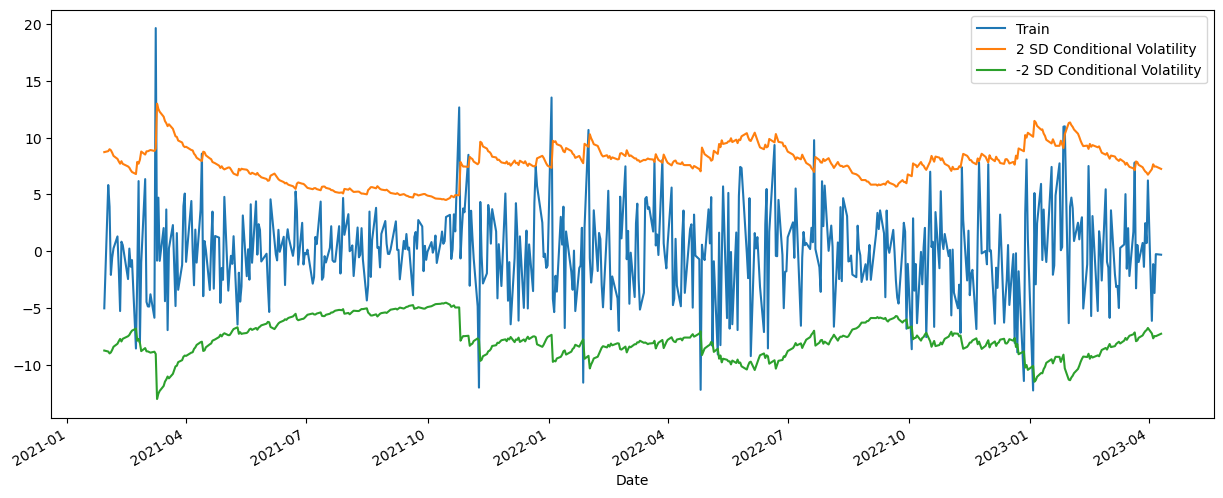

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
df_train.plot(ax=ax,label ='Train')

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(ax=ax,label='2 SD Conditional Volatility')

# Plot conditional volatility * -2
(-2 * model.conditional_volatility).plot(ax=ax,label='-2 SD Conditional Volatility')

# Add axis labels
plt.xlabel('Date')

# Add legend
plt.legend();

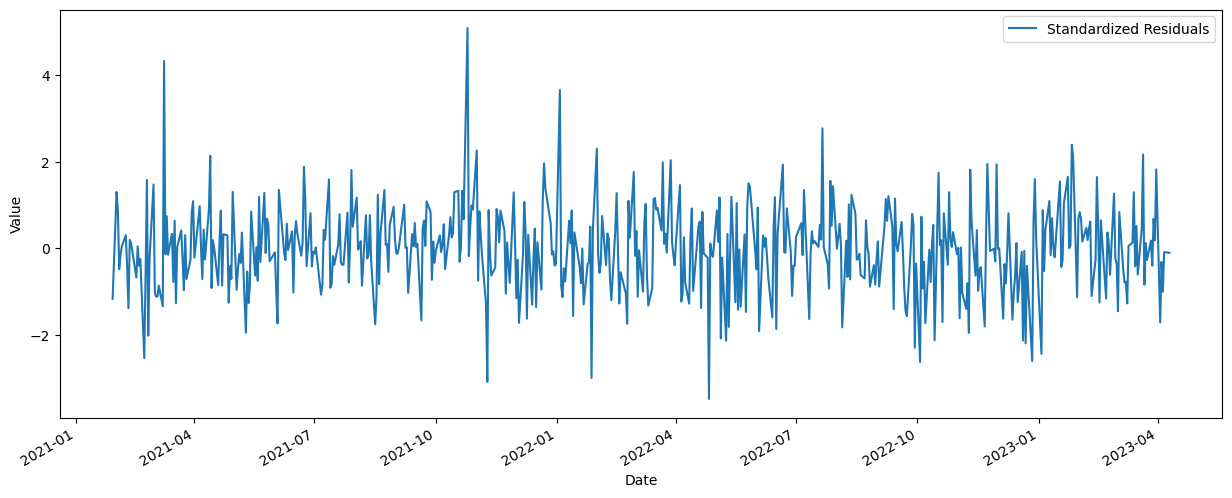

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Value")

# Add legend
plt.legend();

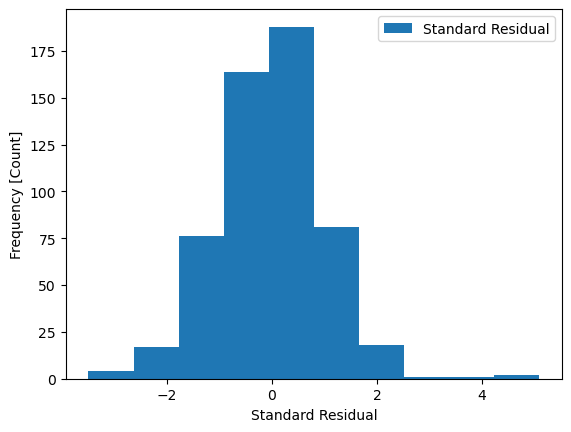

In [29]:
# Create histogram of standardized residuals, 25 bins
plt.hist(model.std_resid,bins=10,label='Standard Residual')

# Add axis labels
plt.xlabel('Standard Residual')
plt.ylabel('Frequency [Count]')

# Add legend
plt.legend();

In [30]:
one_day_forecast = model.forecast(horizon=1,reindex=False).variance

print("one_day_forecast type:", type(one_day_forecast))
np.sqrt(one_day_forecast.iloc[0,0])

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


3.523466932648701

In [31]:
one_day_forecast

,h.1
Date,
2023-04-10,12.414819


In [32]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(df) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = df.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train,p=1,q=1,rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = np.sqrt(model.forecast(horizon=1,reindex=False).variance.iloc[0,0])

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=df.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (137,)


Date
2023-04-11    3.523467
2023-04-12    3.432421
2023-04-13    3.444180
2023-04-14    3.422354
2023-04-17    3.327183
dtype: float64

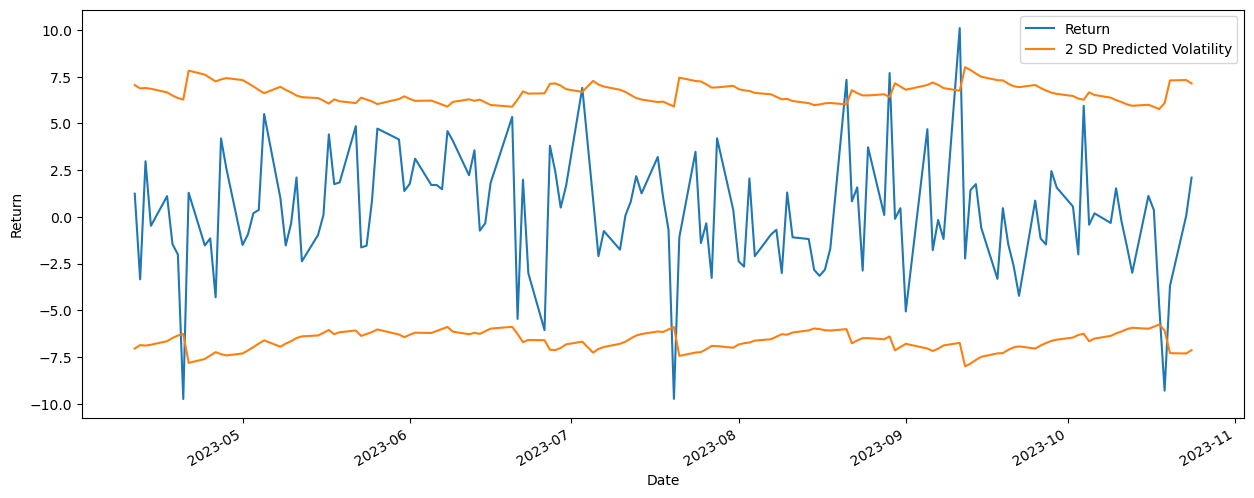

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
df.tail(test_size).plot(ax=ax, label="Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

In [34]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start = prediction.index[0] + pd.DateOffset(days=1)

# Create date range
prediction_dates = pd.bdate_range(start=start,periods=prediction.shape[1])

# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:3]

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2023-10-23  3.566238  3.570478  3.574626  3.578683  3.582651
prediction_index type: <class 'list'>
prediction_index len: 5


['2023-10-24T00:00:00', '2023-10-25T00:00:00', '2023-10-26T00:00:00']

In [35]:
five_day_forecast = model.forecast(horizon=5,reindex=False).variance

In [36]:
five_day_forecast

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2023-10-23,12.718051,12.748315,12.777951,12.806972,12.835391


In [37]:
clean_prediction(prediction)

NameError: name 'clean_prediction' is not defined

In [ ]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days=1)

    # Create date range
    prediction_dates = pd.bdate_range(start=start,periods=prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]

    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten() ** 0.5

    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data,index=prediction_index).to_dict()


    # Return Series as dictionary
    return prediction_formatted

In [ ]:
def save_model(ticker,model):
    """
    Saves the machine learning model for the specified stock ticker to a file using joblib.
    
    Parameters:
    - ticker (str): The stock ticker symbol (e.g., 'TSLA' for Tesla) for which the model is trained.
    - model: Trained machine learning model object to be saved.
    
    Returns:
    - model_file (str): File path where the model is saved with the format '{ticker}.joblib'.
    """
    base_dir = os.getcwd()
    model_file = joblib.dump(model,os.path.join(base_dir,f'{ticker}.joblib'))

    return model_file
        
    